In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import threading
from sklearn.metrics import mean_absolute_error , mean_squared_error
from numpy import mean , concatenate
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation,Layer,Input, Dropout
from numpy import array , hstack
from tensorflow import keras
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split

#Change this to a .py at some point
#lets be real im not gonna do that
%run preprocess_output.ipynb

2024-12-03 12:10:26.546714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733245826.965372 2302359 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733245827.024507 2302359 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 12:10:27.746126: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Data

In [2]:
#runtime: ~10.1 min w/GPU | ~23m w/CPU
columns_to_drop = ["Month_01", "Month_02", "Month_03", "Month_04", "Month_05",
                   "Month_06", "Month_07", "Month_08", "Month_09", "Month_10",
                   "Month_11", "Month_12", "wind_direction", "wind_gust", "Season_summer",
                   "Season_spring", "Season_autumn", "Season_winter"]
#only load this once (it takes a long time)
data_train = get_train_data(columns_to_drop)

In [3]:
dataset_train = data_train.copy()
dataset_train

estimated # arrivals  temperature  wind_speed  \
KATL_220831_0000                   4.0         81.0         5.0   
KATL_220831_2330                   0.0         81.0         5.0   
KATL_220831_2345                   2.0         81.0         5.0   
KATL_220901_0000                  19.0         81.0         5.0   
KATL_220901_0015                  10.0         81.0         5.0   
...                                ...          ...         ...   
KSEA_230429_2245                   0.0         54.0         4.0   
KSEA_230429_2300                   0.0         54.0         4.0   
KSEA_230429_2315                   0.0         54.0         4.0   
KSEA_230429_2330                   0.0         54.0         4.0   
KSEA_230429_2345                   0.0         54.0         4.0   

                  cloud_ceiling  visibility      Time       Day  cloud_BK  \
KATL_220831_0000            8.0         7.0  0.000000  0.867456       0.0   
KATL_220831_2330            8.0         7.0  0.065403  0.867456       0.0   
KATL_220831_2345            8.0         7.0  0.032719  0.867456       0.0   
KATL_220901_0000            8.0         7.0  0.000000  0.863142       0.0   
KATL_220901_0015            8.0         7.0  0.032719  0.863142       0.0   
...                         ...         ...       ...       ...       ...   
KSEA_230429_2245            8.0         7.0  0.162895  0.854322       0.0   
KSEA_230429_2300            8.0         7.0  0.130526  0.854322       0.0   
KSEA_230429_2315            8.0         7.0  0.098017  0.854322       0.0   
KSEA_230429_2330            8.0         7.0  0.065403  0.854322       0.0   
KSEA_230429_2345            8.0         7.0  0.032719  0.854322       0.0   

                  cloud_CL  cloud_FW  ...  Airport_KPHX  Airport_KSEA  \
KATL_220831_0000       0.0       0.0  ...           0.0           0.0   
KATL_220831_2330       0.0       0.0  ...           0.0           0.0   
KATL_220831_2345       0.0       0.0  ...           0.0           0.0   
KATL_220901_0000       0.0       0.0  ...           0.0           0.0   
KATL_220901_0015       0.0       0.0  ...           0.0           0.0   
...                    ...       ...  ...           ...           ...   
KSEA_230429_2245       0.0       0.0  ...           0.0           1.0   
KSEA_230429_2300       0.0       0.0  ...           0.0           1.0   
KSEA_230429_2315       0.0       0.0  ...           0.0           1.0   
KSEA_230429_2330       0.0       0.0  ...           0.0           1.0   
KSEA_230429_2345       0.0       0.0  ...           0.0           1.0   

                  Weekday_friday  Weekday_monday  Weekday_saturday  \
KATL_220831_0000             0.0             0.0               0.0   
KATL_220831_2330             0.0             0.0               0.0   
KATL_220831_2345             0.0             0.0               0.0   
KATL_220901_0000             0.0             0.0               0.0   
KATL_220901_0015             0.0             0.0               0.0   
...                          ...             ...               ...   
KSEA_230429_2245             0.0             0.0               1.0   
KSEA_230429_2300             0.0             0.0               1.0   
KSEA_230429_2315             0.0             0.0               1.0   
KSEA_230429_2330             0.0             0.0               1.0   
KSEA_230429_2345             0.0             0.0               1.0   

                  Weekday_sunday  Weekday_thursday  Weekday_tuesday  \
KATL_220831_0000             0.0               0.0              0.0   
KATL_220831_2330             0.0               0.0              0.0   
KATL_220831_2345             0.0               0.0              0.0   
KATL_220901_0000             0.0               1.0              0.0   
KATL_220901_0015             0.0               1.0              0.0   
...                          ...               ...              ...   
KSEA_230429_2245             0.0               0.0              0.0   
KS

In [4]:
#just making sure the # features lines up
print(f"train # features: {len(dataset_train.columns)} | test # features: {len(dataset_test.columns)}")

NameError: name 'dataset_test' is not defined

/projectnb/cs640grp/students/samwu/Rnn-Forecast/.venv/lib64/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


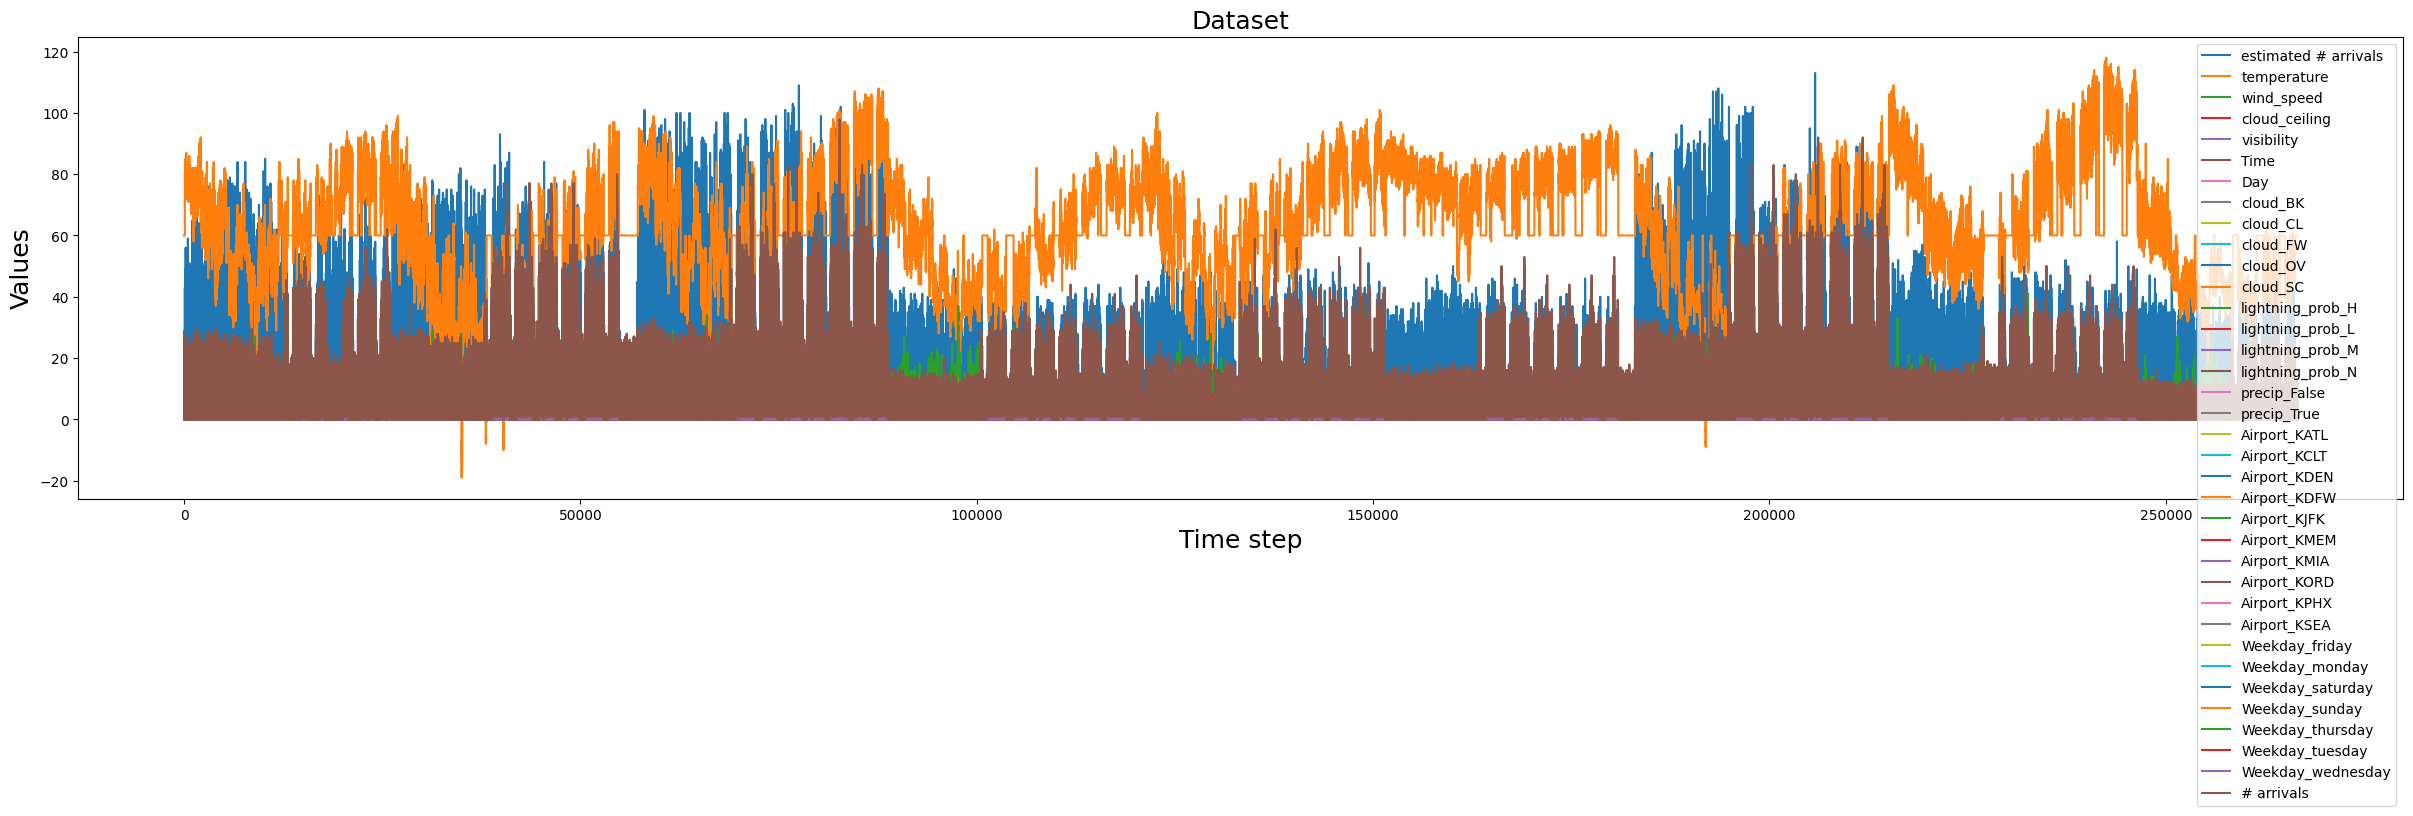

In [ ]:
plt.figure(figsize=(30, 6))
for col in dataset_train.columns:
    plt.plot(dataset_train[col].values, label = col)
plt.legend(loc='upper right')
plt.title("Dataset" ,  fontsize=18)
plt.xlabel('Time step' ,  fontsize=18)
plt.ylabel('Values' , fontsize=18)
plt.legend()
plt.show()

# Preprocess Data

In [ ]:
configed_features = []
scaler = MinMaxScaler(feature_range=(0, 1))
for col in dataset_train.columns:
    # Step 1 : convert to [rows, columns] structure
    x = dataset_train[col].values
    x_reshaped = x.reshape((len(x), 1))
    print (col , x_reshaped.shape) 
    # Step 2 : normalization 
    x_scaled = scaler.fit_transform(x_reshaped)
    configed_features.append(x_scaled)

# Step 3 : horizontally stack columns
dataset_stacked = hstack(configed_features)
print ("dataset_stacked.shape" , dataset_stacked.shape)

estimated # arrivals (266637, 1)
temperature (266637, 1)
wind_speed (266637, 1)
cloud_ceiling (266637, 1)
visibility (266637, 1)
Time (266637, 1)
Day (266637, 1)
cloud_BK (266637, 1)
cloud_CL (266637, 1)
cloud_FW (266637, 1)
cloud_OV (266637, 1)
cloud_SC (266637, 1)
lightning_prob_H (266637, 1)
lightning_prob_L (266637, 1)
lightning_prob_M (266637, 1)
lightning_prob_N (266637, 1)
precip_False (266637, 1)
precip_True (266637, 1)
Airport_KATL (266637, 1)
Airport_KCLT (266637, 1)
Airport_KDEN (266637, 1)
Airport_KDFW (266637, 1)
Airport_KJFK (266637, 1)
Airport_KMEM (266637, 1)
Airport_KMIA (266637, 1)
Airport_KORD (266637, 1)
Airport_KPHX (266637, 1)
Airport_KSEA (266637, 1)
Weekday_friday (266637, 1)
Weekday_monday (266637, 1)
Weekday_saturday (266637, 1)
Weekday_sunday (266637, 1)
Weekday_thursday (266637, 1)
Weekday_tuesday (266637, 1)
Weekday_wednesday (266637, 1)
# arrivals (266637, 1)
dataset_stacked.shape (266637, 36)


In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
 X, y = list(), list()
 for i in range(len(sequences)):
  # find the end of this pattern
  end_ix = i + n_steps_in
  out_end_ix = end_ix + n_steps_out-1
  # check if we are beyond the dataset
  if out_end_ix > len(sequences):
   break
  # gather input and output parts of the pattern
  seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
  X.append(seq_x)
  y.append(seq_y)
 return array(X), array(y)
# choose a number of time steps #change this accordingly
n_steps_in, n_steps_out = 1440 , 1
# covert into input/output
X, y = split_sequences(dataset_stacked, n_steps_in, n_steps_out)
print ("X.shape" , X.shape) 
print ("y.shape" , y.shape)

X.shape (265438, 1200, 35)
y.shape (265438, 1)


In [ ]:
split_point = int(len(X)*.8)

train_X, valid_X = X[:split_point, :], X[split_point:, :]
train_y, valid_y = y[:split_point, :], y[split_point:, :]

# Build the Model

In [ ]:
# Ensure GPU is utilized if available
tf.config.set_visible_devices([], 'GPU')

# Define the number of features based on your input data
n_features = X.shape[2]

# Define a custom layer for input weighting
class InputWeightingLayer(Layer):
    def __init__(self, initial_value=1.0, **kwargs):
        super(InputWeightingLayer, self).__init__(**kwargs)
        self.initial_value = initial_value  # Allow customization of the initial value
    
    def build(self, input_shape):
        # Initialize a trainable weight for x1 (index 0)
        self.weight = self.add_weight(
            name='x1_weight', 
            shape=(1,), 
            initializer=tf.constant_initializer(self.initial_value),  # Use constant initializer with custom value
            trainable=True
        )
    
    def call(self, inputs):
        # Scale x1 (feature at index 0) by the weight
        weighted_x1 = inputs[:, :, 0:1] * self.weight  # Select x1 and scale
        other_features = inputs[:, :, 1:]  # Other features remain unchanged
        return tf.concat([weighted_x1, other_features], axis=-1)

# Register custom layers
tf.keras.utils.get_custom_objects()['InputWeightingLayer'] = InputWeightingLayer

# Define the model with Dropout layers
opt = optimizers.Adam(learning_rate=0.0001)
model = Sequential()
# Add the custom InputWeightingLayer
model.add(InputWeightingLayer(initial_value=1.0, input_shape=(n_steps_in, n_features)))
# Add LSTM layers with Dropout
model.add(LSTM(128, activation='sigmoid', return_sequences=True))
model.add(Dropout(0.2))  # Dropout layer after the first LSTM layer
model.add(LSTM(128, activation='sigmoid', return_sequences=True))
model.add(Dropout(0.2))  # Dropout layer after the first LSTM layer
model.add(LSTM(128, activation='sigmoid', return_sequences=True))
model.add(Dropout(0.2))  # Dropout layer after the first LSTM layer
model.add(LSTM(128, activation='sigmoid'))
model.add(Dropout(0.2))  # Dropout layer after the fourth LSTM layer
# Add Dense layers with Dropout
model.add(Dense(n_steps_out))
model.add(Dropout(0.2))  # Dropout layer before output layer
model.add(Activation('linear'))
# Compile the model
model.compile(loss='mse', optimizer=opt, metrics=['mse'])
# Model summary
model.summary()

/scratch/1332068.1.w/ipykernel_2846218/530923471.py:10: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(InputWeightingLayer, self).__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_weighting_layer_1         │ (None, 1200, 35)       │             1 │
│ (InputWeightingLayer)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1200, 128)      │        83,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1200, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 1200, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1200, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 1200, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1200, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 478,850 (1.83 MB)

 Trainable params: 478,850 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor the validation loss
    patience=15,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored metric
    verbose=1
)
batch_size = 2028
# Train the model with early stopping
history = model.fit(
    train_X, train_y,
    epochs=120,
    batch_size=batch_size,  # Specify the batch size here
    steps_per_epoch=len(train_X) // batch_size,  # Ensure each sample is used once per epoch
    verbose=1,
    validation_data=(valid_X, valid_y),
    shuffle=False,
    callbacks=[early_stopping]  # Early stopping to prevent overfitting
)

# Save the model
model.save('models/w1_l3_128_s1440_b1024.h5')

2024-11-28 11:43:03.380718: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 35674800000 exceeds 10% of free system memory.


Epoch 1/120
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - loss: 0.0964 - mse: 0.0964 

: 

: 

In [8]:
# Load the model and include mse as part of custom_objects
from tensorflow.keras import metrics
loaded_model = tf.keras.models.load_model(
    'models/w1_l3_128_s720_b1024.h5',
    custom_objects={
        'InputWeightingLayer': InputWeightingLayer,
        'mse': metrics.MeanSquaredError()
    }
)

/scratch/1326468.1.l40s/ipykernel_531849/2055422249.py:10: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(InputWeightingLayer, self).__init__(**kwargs)


# Evaluate Model

In [9]:
# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name , start , end):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    corr_matrix = np.corrcoef(actual, predictions)
    corr = corr_matrix[0,1]
    R_sq = corr**2
    print("Test Data from {} to {}".format(start, end))
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('R Squared: {:.4f}'.format(R_sq))
    print('')
    print('')

In [10]:
# Plot history and future
def plot_multistep(history, prediction1 , groundtruth , start , end):
    plt.figure(figsize=(20, 4))
    y_mean = mean(prediction1)
    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction1)))
    plt.plot(np.arange(range_history), np.array(history), label='History')
    plt.plot(range_future, np.array(prediction1),label='Forecasted with LSTM')
    plt.plot(range_future, np.array(groundtruth),label='GroundTruth')
    plt.legend(loc='upper right')
    plt.title("Test Data from {} to {} , Mean = {:.2f}".format(start, end, y_mean) ,  fontsize=18)
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('y-value' , fontsize=18)

In [11]:
data_test = get_test_data(columns_to_drop)
dataset_test = data_test.copy()

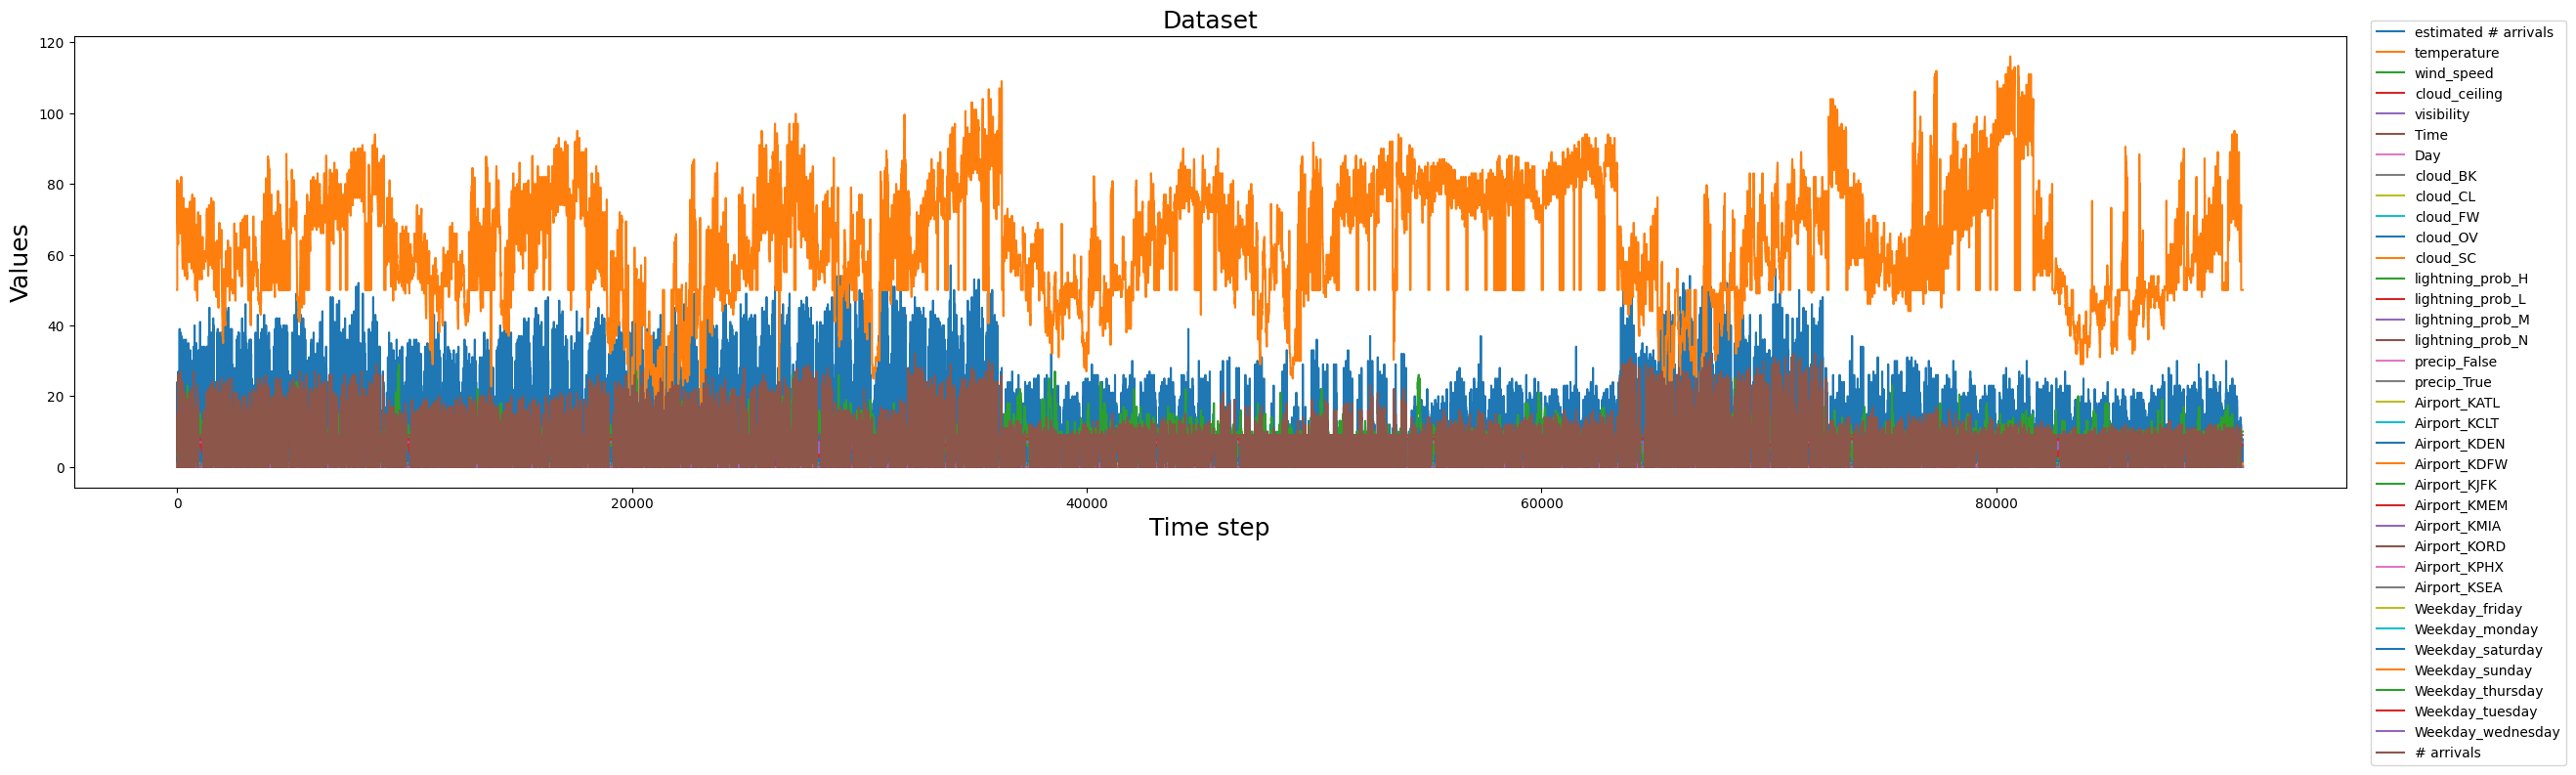

In [13]:
plt.figure(figsize=(30, 6))
for col in dataset_test.columns:
    plt.plot(dataset_test[col].values, label = col)
plt.legend(loc='upper right')
plt.title("Dataset" ,  fontsize=18)
plt.xlabel('Time step' ,  fontsize=18)
plt.ylabel('Values' , fontsize=18)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [12]:
#dataset_x
dataset_x = dataset_test.iloc[:, :-1]
dataset_length = len(dataset_x)
final_x = []
for col in dataset_x:
    x1_test = dataset_x[col].values
    x1_test = x1_test.reshape((len(x1_test), 1))
    x1_test_scaled = scaler.transform(x1_test)
    final_x.append(x1_test_scaled)
formatted_dataset_x = hstack(final_x)

dataset_y = dataset_test.iloc[:, 0]
y_test = dataset_y.values # no need to scale
formatted_dataset_y = y_test.reshape((len(y_test), 1))

In [13]:
def prep_data(formatted_dataset_x, formatted_dataset_y , start , end , last):
  dataset_test_X = formatted_dataset_x[start:end, :]
  test_X_new = dataset_test_X.reshape(1,dataset_test_X.shape[0],dataset_test_X.shape[1])
  
  dataset_test_y = formatted_dataset_y[end:last , :]
  scaler1 = MinMaxScaler(feature_range=(0, 1))
  scaler1.fit(dataset_test_y)

  y_pred = model.predict(test_X_new, verbose=0)
  y_pred_inv = scaler1.inverse_transform(y_pred)
  y_pred_inv = y_pred_inv.reshape(n_steps_out,1)
  y_pred_inv = y_pred_inv[:,0]

  return y_pred_inv

In [14]:
#est ~24 min with GPU
# Shared semaphore and lock
semaphore = threading.Semaphore(8)
list_lock = threading.Lock()
stop_event = threading.Event()

# Shared lists to store predictions and ground truths
y_preds = []
index_list = dataset_test.index.to_list()

def process_data(start, end, last):
  try:
      with semaphore:
          print(f"Starting Thread {start}")
          y_pred= prep_data(formatted_dataset_x, formatted_dataset_y, start, end, last)
          y_pred_rounded =  round(y_pred[0])
          # Ensure thread-safe appending to the lists
          with list_lock:
              y_preds.append(y_pred_rounded)
              print(f"Ended Thread {start}")
  except Exception as e:
      print(f"Exception in thread with start={start}, end={end}, last={last}: {e}")
  except KeyboardInterrupt:
      print("Interrupted by user, stopping threads...")
      # Set the stop flag, signaling threads to stop
      stop_event.set()

def process_data_wrapper(i):
  start = i
  end = start + n_steps_in
  last = end + n_steps_out
  process_data(start, end, last)

# Use ThreadPoolExecutor to manage the maximum number of threads
max_threads = 8
with ThreadPoolExecutor(max_threads) as executor:
  futures = [executor.submit(process_data_wrapper, i) for i in range(dataset_length - n_steps_in)]
  for future in futures:
      future.result()  # This will raise any exceptions encountered in threads

Starting Thread 0
Starting Thread 1
Starting Thread 2
Starting Thread 3
Starting Thread 4
Starting Thread 5
Starting Thread 6
Starting Thread 7


I0000 00:00:1732758536.463362  534565 service.cc:148] XLA service 0x1544f40082d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732758536.463399  534565 service.cc:156]   StreamExecutor device (0): Host, Default Version
2024-11-27 20:48:56.482064: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


I0000 00:00:1732758536.676746  534565 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Ended Thread 7
Starting Thread 8
Ended Thread 6
Starting Thread 9
Ended Thread 4
Starting Thread 10
Ended Thread 3
Starting Thread 11
Ended Thread 1
Starting Thread 12
Ended Thread 2
Starting Thread 13
Ended Thread 0
Starting Thread 14
Ended Thread 5
Starting Thread 15
Ended Thread 11
Starting Thread 16
Ended Thread 10
Starting Thread 17
Ended Thread 8
Starting Thread 18
Ended Thread 9
Starting Thread 19
Ended Thread 14
Starting Thread 20
Ended Thread 13
Starting Thread 21
Ended Thread 15
Starting Thread 22
Ended Thread 12
Starting Thread 23
Ended Thread 16
Starting Thread 24
Ended Thread 17
Starting Thread 25
Ended Thread 18
Starting Thread 26
Ended Thread 19
Starting Thread 27
Ended Thread 22
Starting Thread 28
Ended Thread 21
Starting Thread 29
Ended Thread 23
Starting Thread 30
Ended Thread 20
Starting Thread 31
Ended Thread 24
Starting Thread 32
Ended Thread 25
Starting Thread 33
Ended Thread 27
Starting Thread 34
Ended Thread 26
Starting Thread 35
Ended Thread 31
Starting Thread 

In [ ]:
# for i in range(120,240,60):
#     start = i
#     end = start + n_steps_in 
#     last = end + n_steps_out 
#     y_pred_inv , dataset_test_y , past_data = prep_data(dataset_x, dataset_y, start , end , last)
#     evaluate_prediction(y_pred_inv , dataset_test_y, 'LSTM' , start , end) 
#     plot_multistep(past_data , y_pred_inv , dataset_test_y , start , end)

# PostProcess Output

In [15]:
#predictions are made for n_steps_in timesteps into the future, so the first prediction is for timestamp n_steps_in. 
#This means the first n_steps_in timestamps are ignored 
#My solution right now is to just fill them with 'estimated # arrivals'
#offset = 1
predict_df = pd.DataFrame({"ID":index_list, "Prediction":list(dataset_x[:n_steps_in]["estimated # arrivals"])+y_preds[:]}).set_index('ID')

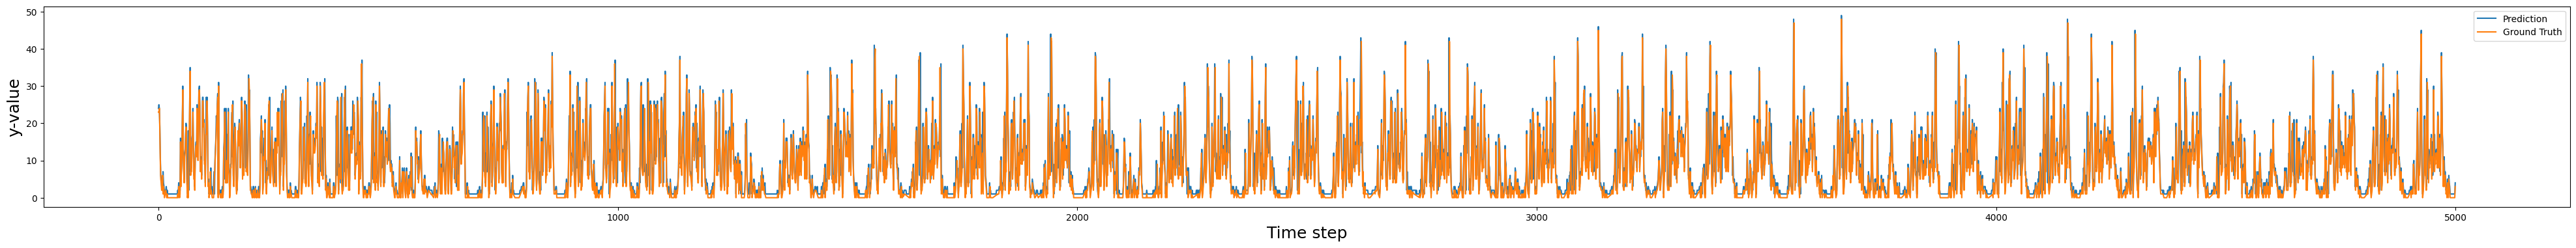

12645
Test Data from 0 to 90837
Mean Absolute Error: 2.0034
Root Mean Square Error: 3.5037
R Squared: 0.8420




In [16]:
plt.figure(figsize=(50, 4))
window = 5000
start = int(np.random.rand()*(len(dataset_y)-window))
plt.xlabel('Time step' ,  fontsize=18)
plt.ylabel('y-value' , fontsize=18)
plt.plot(range(window), predict_df["Prediction"][start:start+window], label = "Prediction")
plt.plot(range(window), dataset_y[start:start+window], label = "Ground Truth")
plt.legend(loc='upper right')
plt.show()
print(start)
evaluate_prediction(np.array(predict_df["Prediction"]), np.array(dataset_y), "LSTM" , 0 , len(dataset_y))

In [17]:
predict_df

Prediction
ID                          
KATL_220924_0000         7.0
KATL_220924_2345         1.0
KATL_220925_0000        24.0
KATL_220925_0015        13.0
KATL_220925_0030        11.0
...                      ...
KSEA_230820_0130         0.0
KSEA_230820_0145         0.0
KSEA_230820_0200         3.0
KSEA_230820_0230         1.0
KSEA_230820_0245         0.0

[90837 rows x 1 columns]

In [17]:
#print the indexes and predictions as a .csv
submission_format_df = pd.read_csv("data/submission_format.csv")
post_process(submission_format_df,predict_df).to_csv("data/submission_w64_l3_128_s720_b1024.csv", index=False)